# Clustering with images using imagebind llm embeddings

In [3]:
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install git+https://github.com/facebookresearch/pytorchvideo.git@28fe037d212663c6a24f373b94cc5d478c8c1a1d timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

Cloning into 'ImageBind'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 112 (delta 43), reused 33 (delta 33), pack-reused 51
Receiving objects: 100% (112/112), 2.64 MiB | 21.96 MiB/s, done.
Resolving deltas: 100% (50/50), done.
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-req-build-rrc01xet
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-req-build-rrc01xet
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d212663c6a

In [4]:
image_paths = ['/content/abomasnow.png', '/content/absol.png', '/content/absol.png', '/content/accelgor.png', '/content/aegislash-blade.png', '/content/aerodactyl.png', '/content/aggron.png', '/content/aipom.png', '/content/alakazam.png','/content/alomomola.png' ]  # Add your image paths here


In [5]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def load_and_transform_vision_data(image_paths, device):
    processed_images = []
    for img_path in image_paths:
        # Load image
        image = Image.open(img_path).convert('RGB')

        # Transform image (adjust as needed for your model)
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize the image
            transforms.ToTensor(),          # Convert to tensor
            # Add any other transformations required by your model
        ])

        # Apply transformation
        image = transform(image).to(device)
        processed_images.append(image)

    # Stack images into a single tensor
    return torch.stack(processed_images)

# Example usage
# image_paths = ['/path/to/image1.jpg', '/path/to/image2.jpg', ...]  # Replace with your image paths
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vision_data = load_and_transform_vision_data(image_paths, device)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
%cd /content/ImageBind
from imagebind import data
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

device = "cuda:0" if torch.cuda.is_available() else "cpu"


# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Load image data only
inputs = {
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
}

with torch.no_grad():
    embeddings = model(inputs)

/content/ImageBind


In [7]:
print(embeddings)

{'vision': tensor([[ 0.0382,  0.0052,  0.0219,  ..., -0.0134, -0.0025, -0.0192],
        [ 0.0172,  0.0056,  0.0362,  ..., -0.0289,  0.0127, -0.0024],
        [ 0.0172,  0.0056,  0.0362,  ..., -0.0289,  0.0127, -0.0024],
        ...,
        [-0.0075, -0.0052,  0.0256,  ...,  0.0054,  0.0131, -0.0359],
        [ 0.0195, -0.0115,  0.0662,  ..., -0.0373,  0.0107, -0.0216],
        [ 0.0121, -0.0182,  0.0204,  ..., -0.0273,  0.0412, -0.0300]],
       device='cuda:0')}


In [12]:
# Extracting the image embeddings tensor from the dictionary
image_embeddings_tensor = embeddings['vision']  # Assuming 'vision' is the key for image embeddings

# Move the tensor to CPU and convert to NumPy array
image_embeddings_np = image_embeddings_tensor.cpu().detach().numpy()

# Now you can proceed with clustering using this NumPy array
# ... (rest of the clustering code)


In [14]:
from sklearn.cluster import KMeans
import numpy as np
import torch

# Convert the tensor to a numpy array if it's not already
# Assuming 'embeddings' is your tensor of embeddings


# Choose the number of clusters
num_clusters = 5  # Modify this based on your needs

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(image_embeddings_np)

# 'clusters' now contains the cluster index for each image


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
!pip install matplotlib scikit-learn


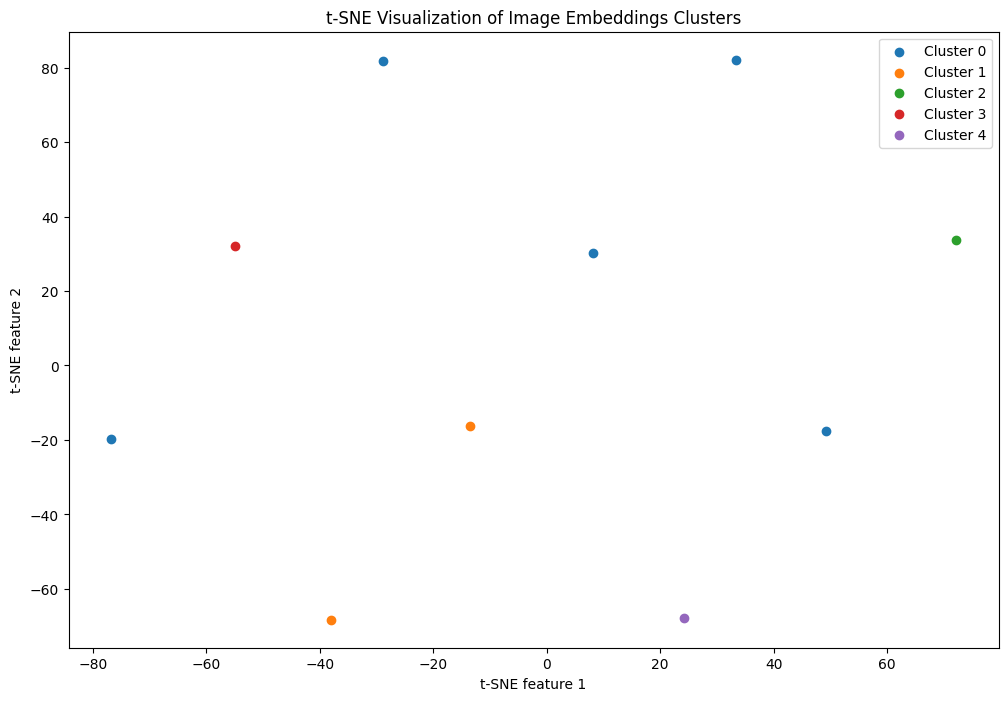

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Choose a perplexity value smaller than the number of image samples
# Adjust this based on your dataset size
perplexity_value = min(30, len(image_embeddings_np) - 1)  # Example: set to 30 or less

# Reduce dimensions to 2D for visualization
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
reduced_embeddings = tsne.fit_transform(image_embeddings_np)

# Plotting
plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    indices = clusters == i
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Cluster {i}')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE Visualization of Image Embeddings Clusters')
plt.legend()
plt.show()
